# Estimating Eddy Diffusivity, K_e

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

$$K_e = K_\rho (\partial_z \theta_e)^2 / (\nabla_n \theta_m)^2$$

- Term 1: $K_rho$
- Term 2: $(\partial_z \theta_e)^2$
- Term 3: $(\nabla_n \theta_m)^2$

$$K_e = K_\rho (\partial_z \theta_e)^2 / |(\nabla_n \theta_m)|^2$$

$$\widetilde{u}\widetilde{T} = \kappa(\frac{\Delta\widetilde{T}}{\Delta z})^2 / (\frac{\Delta\overline{T}}{\Delta x})$$

$\kappa = 10^{-4} \frac{m^2}{s}$

$(\frac{\Delta\widetilde{T}}{\Delta z}) = 0.025 \frac{^\circ C}{m}$, $(\frac{\Delta\widetilde{T}}{\Delta z})^2 = 6.25 x 10^{-4} \frac{^\circ C}{m}$

$(\frac{\Delta\overline{T}}{\Delta x}) = 10^{-4} \frac{^\circ C}{m}$

$\widetilde{u}\widetilde{T} = 6.25 x 10^{-4} \frac{^\circ C m}{s}$

# Functions

In [4]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [5]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [6]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"rho_grid": "density"}).rename_vars({"rho_grid": "density"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"rho_grid": "density"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

## Term (1)

In [7]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [8]:
K_rho = K_rho.rename({'rho_grid':'density'})

## Term (2)

In [50]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [51]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [52]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})

In [53]:
ct_e_z2 = ct_e.differentiate(coord='PRES_INTERPOLATED')**2

In [54]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt)

CPU times: user 1min 59s, sys: 1min 28s, total: 3min 28s
Wall time: 2min 28s


In [56]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

In [58]:
%%time
ct_e_z2_filt_rho = get_ds_rho(ct_e_z2_filt, ds.SIG0, rho_grid, variables=['ct_e_z2_filt', 'PRES_INTERPOLATED'])

Completed comp for ct_e_z2_filt
Completed ct_e_z2_filt


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed merge
CPU times: user 21min 25s, sys: 1min 9s, total: 22min 34s
Wall time: 22min 34s


In [69]:
%%time
term2 = get_ds_binned(ct_e_z2_filt_rho, lon_bins, lat_bins)

CPU times: user 6min 55s, sys: 1min 12s, total: 8min 8s
Wall time: 8min 8s


In [116]:
term2

<xarray.Dataset> Size: 138MB
Dimensions:       (density: 3200, lon_c: 120, lat_c: 45)
Coordinates:
  * density       (density) float64 26kB 21.0 21.0 21.01 ... 28.99 29.0 29.0
  * lat_c         (lat_c) float64 360B -66.0 -63.0 -60.0 ... 60.0 63.0 66.0
    lat_l         (lat_c) float64 360B -67.5 -64.5 -61.5 ... 58.5 61.5 64.5
    lat_r         (lat_c) float64 360B -64.5 -61.5 -58.5 ... 61.5 64.5 67.5
  * lon_c         (lon_c) float64 960B -178.5 -175.5 -172.5 ... 175.5 178.5
    lon_l         (lon_c) int64 960B -180 -177 -174 -171 ... 168 171 174 177
    lon_r         (lon_c) int64 960B -177 -174 -171 -168 ... 171 174 177 180
Data variables:
    ct_e_z2_filt  (density, lon_c, lat_c) float64 138MB dask.array<chunksize=(3200, 120, 45), meta=np.ndarray>

In [71]:
%%time
term2.to_netcdf('/swot/SUM05/amf2288/var-boxes/term2.nc')

CPU times: user 4min 37s, sys: 21min 4s, total: 25min 41s
Wall time: 2min 2s


## Term (3)

In [11]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})

In [12]:
ct_m.name = 'ct_m'
ct_m = ct_m.to_dataset()

In [13]:
%%time
ct_m_rho = get_ds_rho(ct_m, ds.SIG0, rho_grid, variables=['ct_m', 'PRES_INTERPOLATED'])

Completed comp for ct_m
Completed ct_m
Completed merge
CPU times: user 19 s, sys: 11.1 s, total: 30.1 s
Wall time: 30.1 s


In [14]:
%%time
ct_m_rho_binned = get_ds_binned(ct_m_rho, lon_bins, lat_bins)

CPU times: user 18.1 ms, sys: 6.61 ms, total: 24.7 ms
Wall time: 23.5 ms


In [15]:
%%time
term3 = ct_m_rho_binned.differentiate('lon_c').differentiate('lat_c')

CPU times: user 6.8 ms, sys: 0 ns, total: 6.8 ms
Wall time: 6.78 ms


In [16]:
term3

<xarray.Dataset> Size: 138MB
Dimensions:  (density: 3200, lon_c: 120, lat_c: 45)
Coordinates:
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * lat_c    (lat_c) float64 360B -66.0 -63.0 -60.0 -57.0 ... 60.0 63.0 66.0
    lat_l    (lat_c) float64 360B -67.5 -64.5 -61.5 -58.5 ... 58.5 61.5 64.5
    lat_r    (lat_c) float64 360B -64.5 -61.5 -58.5 -55.5 ... 61.5 64.5 67.5
  * lon_c    (lon_c) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
    lon_l    (lon_c) int64 960B -180 -177 -174 -171 -168 ... 165 168 171 174 177
    lon_r    (lon_c) int64 960B -177 -174 -171 -168 -165 ... 168 171 174 177 180
Data variables:
    ct_m     (density, lon_c, lat_c) float64 138MB dask.array<chunksize=(3200, 120, 45), meta=np.ndarray>

In [17]:
term3.to_netcdf('/swot/SUM05/amf2288/var-boxes/term3.nc')

In [ ]:
ct_m_rho_binned_dx = ct_m_rho_binned.differentiate('lon_c')
ct_m_rho_binned_dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_rho_binned_dx.nc')

In [ ]:
ct_m_rho_binned_dy = ct_m_rho_binned.differentiate('lat_c')
ct_m_rho_binned_dy.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_rho_binned_dy.nc')

# Calculations

In [82]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3.nc').rename('term3').load()

CPU times: user 21.7 ms, sys: 454 ms, total: 475 ms
Wall time: 471 ms


In [23]:
K_e = K_rho*term2/term3**2

In [24]:
K_e.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_e.nc')

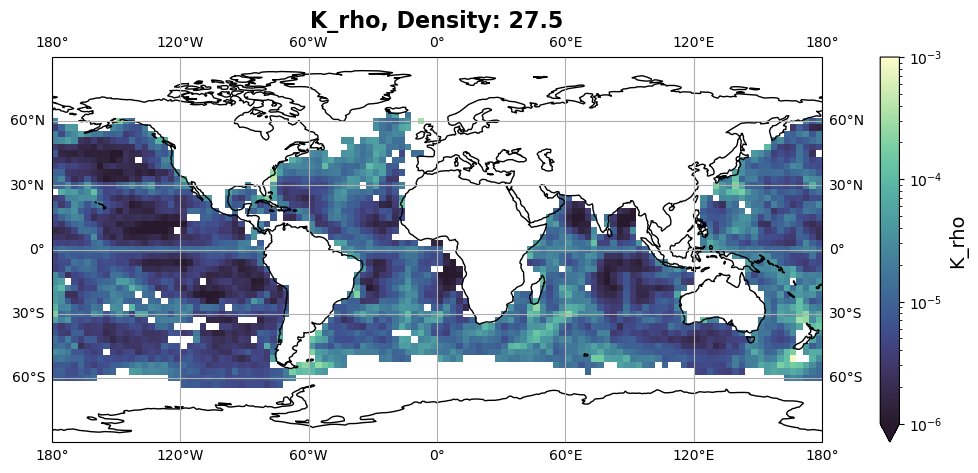

In [85]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

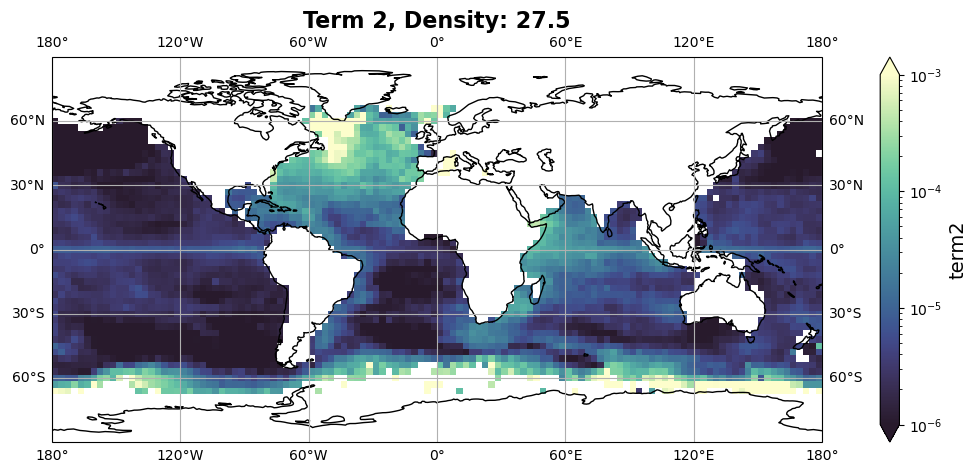

In [99]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_275.png', bbox_inches='tight')

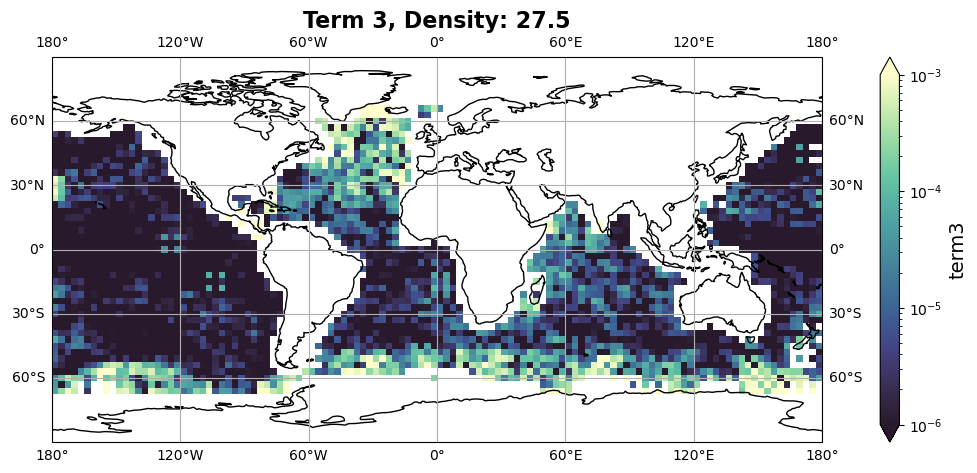

In [87]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
(term3**2).sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term3_275.png', bbox_inches='tight')

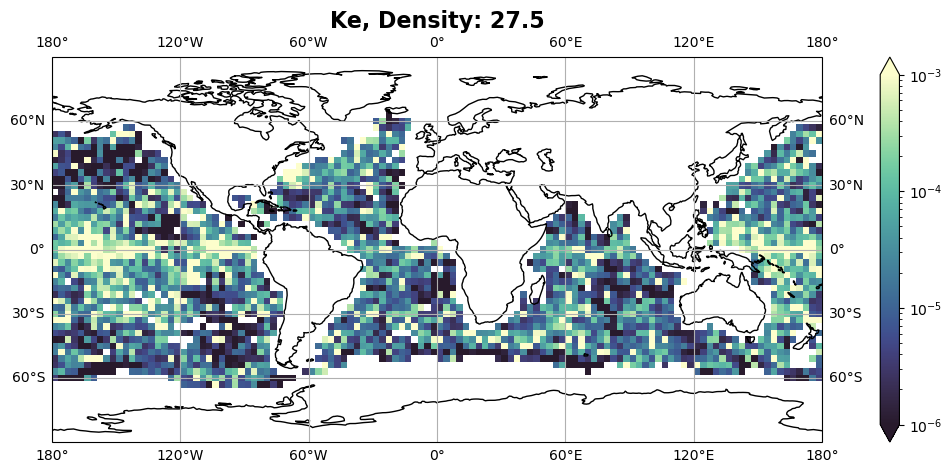

In [88]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_e.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
ax.set_title('Ke, Density: {}'.format(np.round(K_e.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_e_275.png', bbox_inches='tight')